# Custom Actor-Critic implementation and evaluation

## List of Contents

### Provided classes
- [`default_params()`](#default_params) this dictionary defines the default hyper-parameters
- [`TransitionBatch`](#TransitionBatch) the basic class to summarize transitions and build an experience replay buffer.
- [`Runner`](#Runner) interacts with one environment
- [`MultiRunner`](#MultiRunner) runs multiple `Runner` in parallel
- [`QController`](#QController) translates the model outputs into greedy actions
- [`ACController`](#ACController) interprets the first model outputs as logits of a softmax
- [`EpsilonGreedyController`](#EpsilonGreedyController) performs epsilon-greedy exploration
- [`ReinforceLearner`](#ReinforceLearner) trains the model with the REINFORCE algorithm
- [`Experment`](#Experiment) encapsulates and executes a single experiment
- [`ActorCriticExperiment`](#ActorCriticExperiment) performs online Q-learning



### Exercises
- [A3.1a) Run REINFORCE](#q1)
- [A3.1b) Extend REINFORCE with a bias function](#q2)
- [A3.1c) Extend REINFORCE to the vanilla Actor-Critic algorithm](#q3)
- [A3.1d) Extend the Actor-Critic algorithm to off-policy learning](#q4)
- [A3.1e) Implement PPO clipping for off-policy learning](#q5)

In [1]:
# Pytorch and tools
import torch as th
from torch import Tensor, LongTensor
from torch.utils.data import DataLoader
import numpy as np
from copy import deepcopy
import numbers
from datetime import datetime
# Multi-threading
import threading
# Plotting
from IPython import display
import matplotlib.pyplot as plt
import pylab as pl
# Reinforcement learning
import gym
import cv2

This dictionary defines the default hyper-paramerters that you will use in your experiments. <a id=default_params></a>

In [2]:
def default_params():
    """ These are the default parameters used int eh framework. """
    return {# Debugging outputs and plotting during training
            'plot_frequency': 10,             # plots a debug message avery n steps
            'plot_train_samples': True,       # whether the x-axis is env.steps (True) or episodes (False)
            'print_when_plot': True,          # prints debug message if True
            'print_dots': False,              # prints dots for every gradient update
            # Environment parameters
            'env': 'CartPole-v1',             # the environment the agent is learning in
            'run_steps': 2048,                # samples whole episodes if run_steps <= 0
            'max_episode_length': 300,        # maximum number of steps per episode
            # Runner parameters
            'max_episodes': int(1E6),         # experiment stops after this many episodes
            'max_steps': int(2E6),            # experiment stops after this many steps
            'multi_runner': False,             # uses multiple runners if True
            'parallel_environments': 4,       # number of parallel runners  (only if multi_runner==True)
            # Exploration parameters
            'epsilon_anneal_time': int(2),    # exploration anneals epsilon over these many steps
            'epsilon_finish': 1E-5,           # annealing stops at (and keeps) this epsilon 
                                              # epsilon_finish should be 0 for on-policy sampling, 
                                              # but pytorch sometimes produced NaN gradients if probabilities get 
                                              # too close to zero (because then ln(0)=-infty)
            'epsilon_start': 1,               # annealing starts at this epsilon
            # Optimization parameters
            'lr': 5E-4,                       # learning rate of optimizer
            'gamma': 0.99,                    # discount factor gamma
            'batch_size': 2048,               # number of transitions in a mini-batch    
            'grad_norm_clip': 1,              # gradent clipping if grad norm is larger than this 
            # Actor-critic parameters
            'value_loss_param': 0.1,          # governs the relative impact of the value relative to policy loss
            'advantage_bias': True,           # whether the advantages have the value as bias
            'advantage_bootstrap': True,      # whether advantages use bootstrapping (alternatively: returns)
            'offpolicy_iterations': 0,        # how many off-policy iterations are performed
            'value_targets': 'returns',       # either 'returns' or 'td' as regression targets of the value function
            # PPO parameters
            'ppo_clipping': True,             # whether we use the PPO loss
            'ppo_clip_eps': 0.1,              # the epsilon for the PPO loss
            # Image input parameters (not used in this exercise)         
            'pixel_observations': False,      # use pixel observations (we will not use this feature here)
            'pixel_resolution': (78, 78),     # scale image to this resoluton
            'pixel_grayscale': True,          # convert image into grayscale
            'pixel_add_last_obs': True,       # stacks 2 observations
            'pixel_last_obs_delay': 3,        # delay between the two stacked observations
           }

`TransitionBatches` are dictionaries of variables, e.g. states or actions, that are saved in contiguous Tensors. <a id=TransitionBatch></a>

In [3]:
# Same as in exercise sheet 2
class TransitionBatch:
    """ Simple implementation of a batchof transitionsm (or another dictionary-based tensor structure).
        Read and write operations are thread-safe, but the iterator is not (you cannot interate
        over the same TransitionBatch in two threads at the same time). """
    def __init__(self, max_size, transition_format, batch_size=32):
        self.lock = threading.Lock()
        self.indices = []
        self.size = 0
        self.first = 0
        self.max_size = max_size
        self.batch_size = batch_size
        self.dict = {}
        for key, spec in transition_format.items():
            self.dict[key] = th.zeros([max_size, *spec[0]], dtype=spec[1])
            
    def _clone_empty_batch(self, max_size=None, batch_size=None):
        """ Clones this TransitionBatch without cloning the data. """
        max_size = self.max_size if max_size is None else max_size
        batch_size = self.batch_size if batch_size is None else batch_size
        return TransitionBatch(max_size=max_size, transition_format={}, batch_size=batch_size)
        
    def __getitem__(self, key):
        """ Access the TransitionBatch with the [] operator. Use as key either 
            - the string name of a variable to get the full tensor of that variable,
            - a slice to get a time-slice over all variables in the batch,
            - a LongTensor that selects a subset of indices for all variables in the batch. """
        # Return the entry of the transition called "key"
        if isinstance(key, str): 
            return self.dict[key]
        # Return a slice of the batch
        if isinstance(key, slice):
            key = slice(0 if key.start is None else key.start, self.size if key.stop is None else key.stop,
                        1 if key.step is None else key.step)
            self.lock.acquire()
            try:
                batch = self._clone_empty_batch()
                batch.size = (key.stop - key.start) // key.step 
                for k, v in self.dict.items():
                    batch.dict[k] = v[key] 
            finally: self.lock.release()
            return batch
        # Collect and return a set of transitions specified by the LongTensor "key" 
        if isinstance(key, th.Tensor):
            self.lock.acquire()
            try:
                batch = self._clone_empty_batch(max_size=key.shape[0])
                batch.size = key.shape[0]
                for k, v in self.dict.items():
                    key = key.view(batch.size, *[1 for _ in range(len(v.shape[1:]))])
                    batch.dict[k] = v.gather(dim=0, index=key.expand(batch.size, *v.shape[1:]))
            finally: self.lock.release()
            return batch
        return None
    
    def get_first(self):
        """ Returns a batch of the oldest entries of all variables. """
        batch = self._clone_empty_batch(max_size=1)
        self.lock.acquire()
        try:
            batch.size = 1
            for k, v in self.dict.items():
                batch.dict[k] = v[self.first].unsqueeze(dim=0)
        finally: self.lock.release()
        return batch    
    
    def get_last(self):
        """ Returns a batch of the newest entries of all variables. """
        batch = self._clone_empty_batch(max_size=1)
        self.lock.acquire()
        try:
            batch.size = 1
            for j, v in self.dict.items():
                batch.dict[k] = v[(self.first + self.size - 1) % self.size].unsqueeze(dim=0)
        finally: self.lock.release()
        return batch
    
    def add(self, trans:dict):
        """ Adding transition dictionaries, which can contain Tensors of arbitrary length. """
        if isinstance(trans, TransitionBatch):
            trans = trans.dict
        # Add all data in the dict
        self.lock.acquire()
        try:
            n = 0
            idx = None
            for k, v in trans.items():
                if idx is None:
                    n = v.shape[0]
                    idx = th.LongTensor([(self.first + self.size + i) % self.max_size for i in range(n)])
                else:
                    assert n == v.shape[0], 'all tensors in a transition need to have the same batch_size'
                idx = idx.view(idx.shape[0], *[1 for _ in range(len(v.shape) - 1)])
                self.dict[k].scatter_(dim=0, index=idx.expand_as(v), src=v)
            # Increase the size (and handle overflow)
            self.size += n
            if self.size > self.max_size:
                self.first = (self.first + n) % self.max_size
                self.size = self.max_size
        finally: self.lock.release()
        return self
            
    def trim(self):
        """ Reduces the length of the max_size to its actual size (in-place). Returns self. """
        self.lock.acquire()
        try:
            for k, v in self.dict.items():
                self.dict[k] = v[:self.size]
            self.max_size = self.size
        finally: self.lock.release()
        return self
    
    def replace(self, batch, index=0):
        """ Replaces parts of this batch with another batch (which must be smaller). """
        self.lock.acquire()
        try:
            #assert batch.max_size <= self.max_size - index, "Replacement is larger then target area in batch."
            assert batch.size <= self.max_size - index, "Replacement is larger then target area in batch."
            for k, v in batch.dict.items():
                if batch.size < batch.max_size:
                    v = v[:batch.size]
                self.dict[k][index:(index + batch.max_size)] = v    
        finally: self.lock.release()
    
    def sample(self):
        """ Samples a random mini-batch from the batch. """
        return self[th.randint(high=self.size, size=(self.batch_size,1))]
            
    def __len__(self): 
        """ Returns the length of the batch. """
        return self.size
    
    def __iter__(self):  
        """ Initializes an iterator over the batch. """
        self.indices = list(range(self.size))
        np.random.shuffle(self.indices)
        return self
    
    def __next__(self):  
        """ Iterates through batch, returns list of contiguous tensors. """
        if len(self.indices) == 0: raise StopIteration
        size = min(self.batch_size, len(self.indices))
        batch = self[th.LongTensor(self.indices[-size:])]
        self.indices = self.indices[:-size]
        return batch

`Runner` implements a simple runner class that uses a controller to interact with the environment by calling `run()` or `run_episode()`. <a id=Runner></a>

In [4]:
# same as in exercise sheet 2
class Runner:
    """ Implements a simple single-thread runner class. """
    def __init__(self, controller, params={}, exploration_step=1):
        self.env = gym.make(params.get('env', 'CartPole-v0'))
        self.cont_actions = isinstance(self.env.action_space, gym.spaces.Box)
        self.controller = controller
        self.epi_len = params.get('max_episode_length', self.env._max_episode_steps)
        self.gamma = params.get('gamma', 0.99)
        self.use_pixels = params.get('pixel_observations', False)
        if self.use_pixels:
            self.grayscale = params.get('pixel_grayscale', True)
            self.add_last_obs = params.get('pixel_add_last_obs', False)
            self.last_obs_delay = params.get('pixel_last_obs_delay', 4)
            n_colors = 1 if self.grayscale else 3
            n_feats = n_colors * (2 if self.add_last_obs else 1)
            resolution = params.get('pixel_resolution', (25, 25))
            self.state_shape = (n_feats, *resolution)
            self.last_observations = TransitionBatch(max_size=self.last_obs_delay, 
                                                     transition_format={'img': ((n_colors, *resolution), th.float32)})
        else:
            self.state_shape = self.env.observation_space.shape
        # Set up current state and time step
        self.sum_rewards = 0
        self.state = None
        self.time = 0
        self._next_step() 
        
    def close(self):
        """ Closes the underlying environment. Should always when ending an experiment. """
        self.env.close()
    
    def transition_format(self):
        """ Returns the format of transtions: a dictionary of (shape, dtype) entries for each key. """
        return {'actions': ((1,), th.long),
                'states': (self.state_shape, th.float32),
                'next_states': (self.state_shape, th.float32),
                'rewards': ((1,),  th.float32),
                'dones': ((1,), th.bool),
                'returns': ((1,), th.float32)}
    
    def _wrap_transition(self, s, a, r, ns, d):
        """ Takes a transition and returns a corresponding dictionary. """
        trans = {}
        form = self.transition_format()
        for key, val in [('states', s), ('actions', a), ('rewards', r), ('next_states', ns), ('dones', d)]:
            if not isinstance(val, th.Tensor): 
                if isinstance(val, numbers.Number) or isinstance(val, bool): val = [val]
                val = th.tensor(val, dtype=form[key][1])
            if len(val.shape) < len(form[key][0]) + 1: val = val.unsqueeze(dim=0)
            trans[key] = val
        return trans
    
    def _pixel_observation(self, reset=False):
        """ Returns the pixel-observation fo the current state. Opens extra window for rendering. """
        img = self.env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=self.state_shape[1:], interpolation=cv2.INTER_CUBIC)
        img = th.from_numpy(img.astype(np.float32) / 255).transpose(dim0=0, dim1=2).unsqueeze(dim=0)
        if self.grayscale: img = img.mean(dim=1, keepdim=True)
        if self.add_last_obs:
            if reset: self.last_observations.size = 0
            if self.last_observations.size < self.last_observations.max_size:
                obs = img * 0
            else:
                obs = self.last_observations.get_first()['img'].clone()
            self.last_observations.add({'img': img})
            img = th.cat([obs, img], dim=1)
        return img
    
    def _run_step(self, a):
        """ Make a step in the environment (and update internal bookeeping) """
        ns, r, t, d, _ = self.env.step(a.item())
        self.sum_rewards += r
        if self.use_pixels: ns = self._pixel_observation()
        return r, ns, t, d or t  # reward, next state, terminal, done
    
    def _next_step(self, done=True, next_state=None):
        """ Switch to the next time-step (and update internal bookeeping) """
        self.time = 0 if done else self.time + 1
        if done:
            self.sum_rewards = 0
            self.state, _ = self.env.reset()
            if self.use_pixels: self.state = self._pixel_observation(reset=True)
        else:
            self.state = next_state
    
    def run(self, n_steps, transition_buffer=None, trim=True, return_dict=None):
        """ Runs n_steps in the environment and stores them in the trainsition_buffer (newly created if None).
            If n_steps <= 0, stops at the end of an episode and optionally trins the transition_buffer.
            Returns a dictionary containing the transition_buffer and episode statstics. """
        my_transition_buffer = TransitionBatch(n_steps if n_steps > 0 else self.epi_len, self.transition_format())
        time, episode_start, episode_lengths, episode_rewards = 0, 0, [], []
        max_steps = n_steps if n_steps > 0 else self.epi_len
        for t in range(max_steps):
            # One step in the envionment
            a = self.controller.choose(self.state)
            r, ns, terminal, done = self._run_step(a)
            my_transition_buffer.add(self._wrap_transition(self.state, a, r, ns, terminal)) 
            if self.env._elapsed_steps == self.epi_len: done = True
            # Compute discounted returns if episode has ended or max_steps has been reached
            if done or t == (max_steps - 1):
                my_transition_buffer['returns'][t] = my_transition_buffer['rewards'][t]
                for i in range(t - 1, episode_start - 1, -1):
                    my_transition_buffer['returns'][i] = my_transition_buffer['rewards'][i] \
                                                         + self.gamma * my_transition_buffer['returns'][i + 1]
                episode_start = t + 1
            # Remember statistics and advance (potentially initilaizing a new episode)
            if done:
                episode_lengths.append(self.time + 1)
                episode_rewards.append(self.sum_rewards)
            self._next_step(done=done, next_state=ns)
            time += 1
            # If n_steps <= 0, we return after one episode (trimmed if specified)
            if done and n_steps <= 0: 
                my_transition_buffer.trim()
                break
        # Add the sampled transitions to the given transition buffer
        transition_buffer = my_transition_buffer if transition_buffer is None \
                            else transition_buffer.add(my_transition_buffer)
        if trim: transition_buffer.trim()
        # Return statistics (mean reward, mean length and environment steps)
        if return_dict is None: return_dict = {}
        return_dict.update({'buffer': transition_buffer,
                            'episode_reward': None if len(episode_rewards) == 0 else np.mean(episode_rewards),
                            'episode_length': None if len(episode_lengths) == 0 else np.mean(episode_lengths),
                            'env_steps': time})
        return return_dict
        
    def run_episode(self, transition_buffer=None, trim=True, return_dict=None):
        """ Runs one episode in the environemnt. 
            Returns a dictionary containing the transition_buffer and episode statstics. """
        return self.run(0, transition_buffer, trim, return_dict)

`MultiRunner` runs a number of `Runner` instances in parallel. <a id=MultiRunner></a>

In [5]:
# Same as in exercise sheet 2
class MultiRunner:
    """ Simple class that runs multiple Runner objects in parallel and merges their outputs. """
    def __init__(self, controller, params={}):
        self.workers = []
        self.runners = []
        n = params.get('parallel_environments', 1)
        for _ in range(n):
            self.runners.append(Runner(controller=controller, params=params))
            
    def transition_format(self):
        """ Same transition-format as underlying Runners. """
        return self.runners[0].transition_format()
    
    def close(self):
        """ Closes the underlying environment. Should always when ending an experiment. """
        # Join all workers
        for w in self.workers:
            w.join()
        # Exit all environments
        for r in self.runners:
            r.close()
    
    def fork(self, target, common_args=None, specific_args=None):
        """ Executes the function "target" on all runners. "common_args" is a dictionary of 
            arguments that are passed to all runners, "specific_args" is a list of 
            dictionaries that contain individual parameters for each runner. """ 
        # Fork all runners
        self.workers = []
        for i, r in enumerate(self.runners):
            r_args = [] if specific_args is None else [arg[i] for arg in specific_args]
            self.workers.append(threading.Thread(target=target, args=(r, *common_args, *r_args)))
            self.workers[-1].start()
        # Join all runners
        for w in self.workers:
            w.join()
    
    def run(self, n_steps, transition_buffer=None, trim=True):
        """ Runs n_steps, split amongst runners, and stores them in the trainsition_buffer (newly created if None).
            If n_steps <= 0, stops at the end of an episode and optionally trims the transition_buffer.
            Returns a dictionary containing the transition_buffer and episode statstics. """
        n_steps = n_steps // len(self.runners)
        if transition_buffer is None:
            buffer_len = len(self.runners) * (n_steps if n_steps > 0 else self.runners[0].epi_len)
            transition_buffer = TransitionBatch(buffer_len, self.runners[0].transition_format())
        return_dicts = [{} for _ in self.runners]
        self.fork(target=Runner.run, common_args=(n_steps, transition_buffer, False), specific_args=(return_dicts,))
        if trim: transition_buffer.trim()
        rewards = [d['episode_reward'] for d in return_dicts if d['episode_reward'] is not None]
        lengths = [d['episode_length'] for d in return_dicts if d['episode_reward'] is not None]
        return {'buffer': transition_buffer, 
                'episode_reward': np.mean(rewards) if len(rewards) > 0 else None,
                'episode_length': np.mean(lengths) if len(lengths) > 0 else None,
                'env_steps': len(transition_buffer)}

    def run_episode(self, transition_buffer=None, trim=True):
        """ Runs one episode in the environemnt. 
            Returns a dictionary containing the transition_buffer and episode statstics. """
        return self.run(0, transition_buffer, trim)

A `QController` translates model responses into actions. Call `choose()` to select actions or `probabilities()` to get the probabilities with which the controller would choose the actions. <a id=QController></a>

In [6]:
# Same as in exercise sheet 2
class QController:
    """ Controller for Q-value functions, synchronizes the model calls. """
    def __init__(self, model, num_actions=None, params={}):
        self.lock = threading.Lock()
        self.num_actions = model[-1].out_features if num_actions is None else num_actions
        self.model = model
        
    def copy(self):
        """ Shallow copy of this controller that does not copy the model. """
        return QController(model=self.model, num_actions=self.num_actions)
        
    def parameters(self):
        """ Returns a generator of the underlying model parameters. """
        return self.model.parameters()
    
    def sanitize_inputs(self, observation, **kwargs):
        """ Casts numpy arrays as Tensors. """
        if isinstance(observation, np.ndarray):
            observation = th.Tensor(observation).unsqueeze(dim=0)
        return observation
                
    def choose(self, observation, **kwargs):
        """ Returns the greedy actions the agent would choose when facing an "observation". """
        self.lock.acquire()
        try: 
            mx = self.model(self.sanitize_inputs(observation))
            if mx.shape[-1] > self.num_actions: mx = mx[:, :self.num_actions]
        finally: self.lock.release()
        return th.max(mx, dim=-1)[1]

    def probabilities(self, observation, **kwargs):
        """ Returns the probabilities with which the agent would choose actions (here one-hot because greedy). """
        self.lock.acquire()
        try: 
            mx = self.model(self.sanitize_inputs(observation))
            if mx.shape[-1] > self.num_actions: mx = mx[:, :self.num_actions]
        finally: self.lock.release()
        return th.zeros(*mx.shape).scatter_(dim=-1, index=th.max(mx, dim=-1)[1].unsqueeze(dim=-1), src=th.ones(1, 1))

An `ACController` overwrites the `QController` and interpretes the model output as logits of a softmax policy (followed by additional outputs, like a value head, that are of no interest to the contoller).  <a id=ACController></a>

In [7]:
class ACController (QController):
    """ A controller that interprets the first num_actions model outputs as logits of a softmax distribution. """
    def probabilities(self, observation, precomputed=False, **kwargs):
        self.lock.acquire()
        try: mx = observation if precomputed else self.model(self.sanitize_inputs(observation))[:, :self.num_actions] 
        finally: self.lock.release()
        return th.nn.functional.softmax(mx, dim=-1)

    def choose(self, observation, **kwargs):
        return th.distributions.Categorical(probs=self.probabilities(observation, **kwargs)).sample()

An `EpsilonGreedyController` is a controller that autonomously anneals an expsilon greedy exploration strategy. <a id=EpsilonGreedyController></a>

In [8]:
# Same as in exercise sheet 2
class EpsilonGreedyController:
    """ A wrapper that makes any controller into an epsilon-greedy controller. 
        Keeps track of training-steps to decay exploration automatically. """
    def __init__(self, controller, params={}, exploration_step=1):
        self.controller = controller
        self.num_actions = controller.num_actions
        self.max_eps = params.get('epsilon_start', 1.0)
        self.min_eps = params.get('epsilon_finish', 0.05)
        self.anneal_time = int(params.get('epsilon_anneal_time', 10000) / exploration_step)
        self.num_decisions = 0
    
    def epsilon(self):
        """ Returns current epsilon. """
        return max(1 - self.num_decisions / (self.anneal_time - 1), 0) \
                * (self.max_eps - self.min_eps) + self.min_eps
    
    def choose(self, observation, increase_counter=True, **kwargs):
        """ Returns the (possibly random) actions the agent takes when faced with "observation".
            Decays epsilon only when increase_counter=True". """
        eps = self.epsilon()
        if increase_counter: self.num_decisions += 1
        if np.random.rand() < eps: 
            return th.randint(self.controller.num_actions, (1,), dtype=th.long)
        else: 
            return self.controller.choose(observation, **kwargs)
    
    def probabilities(self, observation, **kwargs):
        """ Returns the probabilities with which the agent would choose actions. """
        eps = self.epsilon()
        return eps * th.ones(1, 1) / self.num_actions + \
               (1 - eps) * self.controller.probabilities(observation, **kwargs) 

A `ReinforceLearner` is a learner class that trains an actor-critic model with the REINFORCE algorithm. <a id=ReinforceLearner></a>

In [9]:
class ReinforceLearner:
    """ A learner that performs a version of REINFORCE. """
    def __init__(self, model, controller=None, params={}):
        self.model = model
        self.controller = controller
        self.value_loss_param = params.get('value_loss_param', 1)
        self.offpolicy_iterations = params.get('offpolicy_iterations', 0)
        self.all_parameters = list(model.parameters())
        self.optimizer = th.optim.Adam(self.all_parameters, lr=params.get('lr', 5E-4))
        self.grad_norm_clip = params.get('grad_norm_clip', 10)
        self.compute_next_val = False  # whether the next state's value is computed
        self.old_pi = None  # this variable can be used for your PPO implementation
        
    def set_controller(self, controller):
        """ This function is called in the experiment to set the controller. """
        self.controller = controller
    
    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        return batch['returns']
    
    def _value_loss(self, batch, values=None, next_values=None):
        """ Computes the value loss (if there is one). """
        return 0
    
    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        return -(advantages.detach() * pi.log()).mean()

    def train(self, batch):
        assert self.controller is not None, "Before train() is called, a controller must be specified. "
        self.model.train(True)
        self.old_pi, loss_sum = None, 0.0
        for _ in range(1 + self.offpolicy_iterations):
            # Compute the model-output for given batch
            out = self.model(batch['states'])   # compute both policy and values
            val = out[:, -1].unsqueeze(dim=-1)  # last entry are the values
            next_val = self.model(batch['next_states'])[:, -1].unsqueeze(dim=-1) if self.compute_next_val else None
            pi = self.controller.probabilities(out[:, :-1], precomputed=True).gather(dim=-1, index=batch['actions'])
            # Combine policy and value loss
            loss = self._policy_loss(pi, self._advantages(batch, val, next_val)) \
                    + self.value_loss_param * self._value_loss(batch, val, next_val)
            # Backpropagate loss
            self.optimizer.zero_grad()
            loss.backward()
            grad_norm = th.nn.utils.clip_grad_norm_(self.all_parameters, self.grad_norm_clip)
            self.optimizer.step()
            loss_sum += loss.item()
        return loss_sum

An `Experiment` is an abstract class that starts and maintains a single learning experiment (i.e. random seed). The experiment is started using `run()` and can be interrupted at any time using `close()`. Afterwards the experiment can be restarted at any time calling `run()` again. <a id=Experiment></a>

In [10]:
# Same as in exercise sheet 2
class Experiment:
    """ Abstract class of an experiment. Contains logging and plotting functionality."""
    def __init__(self, params, model, **kwargs):
        self.params = params
        self.plot_frequency = params.get('plot_frequency', 100)
        self.plot_train_samples = params.get('plot_train_samples', True)
        self.print_when_plot = params.get('print_when_plot', False)
        self.print_dots = params.get('print_dots', False)
        self.episode_returns = []
        self.episode_lengths = []
        self.episode_losses  = []
        self.env_steps = []
        self.total_run_time = 0.0
        
    def plot_training(self, update=False):
        """ Plots logged training results. Use "update=True" if the plot is continuously updated
            or use "update=False" if this is the final call (otherwise there will be double plotting). """ 
        # Smooth curves
        window = max(int(len(self.episode_returns) / 50), 10)
        if len(self.episode_losses) < window + 2: return
        returns = np.convolve(self.episode_returns, np.ones(window)/window, 'valid')
        lengths = np.convolve(self.episode_lengths, np.ones(window)/window, 'valid')
        losses = np.convolve(self.episode_losses, np.ones(window)/window, 'valid')
        env_steps = np.convolve(self.env_steps, np.ones(window)/window, 'valid')
        # Determine x-axis based on samples or episodes
        if self.plot_train_samples:
            x_returns = env_steps
            x_losses = env_steps[(len(env_steps) - len(losses)):]
        else:
            x_returns = [i + window for i in range(len(returns))]
            x_losses = [i + len(returns) - len(losses) + window for i in range(len(losses))]
        # Create plot
        colors = ['b', 'g', 'r']
        fig = plt.gcf()
        fig.set_size_inches(16, 4)
        plt.clf()
        # Plot the losses in the left subplot
        pl.subplot(1, 3, 1)
        pl.plot(env_steps, returns, colors[0])
        pl.xlabel('environment steps' if self.plot_train_samples else 'episodes')
        pl.ylabel('episode return')
        # Plot the episode lengths in the middle subplot
        ax = pl.subplot(1, 3, 2)
        ax.plot(env_steps, lengths, colors[0])
        ax.set_xlabel('environment steps' if self.plot_train_samples else 'episodes')
        ax.set_ylabel('episode length')
        # Plot the losses in the right subplot
        ax = pl.subplot(1, 3, 3)
        ax.plot(x_losses, losses, colors[0])
        ax.set_xlabel('environment steps' if self.plot_train_samples else 'episodes')
        ax.set_ylabel('loss')
        # dynamic plot update
        display.clear_output(wait=True)
        if update:
            display.display(pl.gcf())
    
    def close(self):
        """ Frees all allocated runtime ressources, but allows to continue the experiment later. 
            Calling the run() method after close must be able to pick up the experiment where it was. """
        pass
    
    def run(self):
        """ Starts (or continues) the experiment. """
        assert False, "You need to extend the Expeirment class and override the method run(). "

`ActorCriticExperiment` performs policy gradient learning using `ReinforceLearner`. One can specify another learner, which you will do in later exercises. <a id=ActorCriticExperiment></a>

In [11]:
class ActorCriticExperiment (Experiment):
    def __init__(self, params, model, learner=None, **kwargs):
        super().__init__(params, model, **kwargs)
        self.max_episodes = params.get('max_episodes', int(1E6))
        self.max_steps = params.get('max_steps', int(1E9))
        self.grad_repeats = params.get('grad_repeats', 1)
        self.batch_size = params.get('batch_size', 1024)
        self.controller = ACController(model, num_actions=gym.make(params['env']).action_space.n, params=params)
        self.controller = EpsilonGreedyController(controller=self.controller, params=params)
        self.runner = MultiRunner(self.controller, params=params) if params.get('multi_runner', True) \
                      else Runner(self.controller, params=params)
        self.learner = ReinforceLearner(model, params=params) if learner is None else learner
        self.learner.set_controller(self.controller)

    def close(self):
        """ Overrides Experiment.close() """
        self.runner.close()

    def run(self):
        """ Overrides Experiment.run() """
        # Plot past results if available
        if self.plot_frequency is not None and len(self.episode_losses) > 2:
            self.plot_training(update=True)
        # Run the experiment
        transition_buffer = TransitionBatch(self.batch_size, self.runner.transition_format(), self.batch_size)
        env_steps = 0 if len(self.env_steps) == 0 else self.env_steps[-1]
        for e in range(self.max_episodes):
            # Run the policy for batch_size steps
            batch = self.runner.run(self.batch_size, transition_buffer)
            env_steps += batch['env_steps']
            if batch['episode_length'] is not None:
                self.env_steps.append(env_steps)
                self.episode_lengths.append(batch['episode_length'])
                self.episode_returns.append(batch['episode_reward'])
            # Make a gradient update step
            loss = self.learner.train(batch['buffer'])
            self.episode_losses.append(loss)
            # Quit if maximal number of environment steps is reached
            if env_steps >= self.max_steps: break
            # Show intermediate results
            if self.print_dots:
                print('.', end='')
            if self.plot_frequency is not None and (e + 1) % self.plot_frequency == 0 \
                                               and len(self.episode_losses) > 2:
                self.plot_training(update=True)
                if self.print_when_plot:
                    print('Iteration %u, 100-epi-return %.4g +- %.3g, length %u, loss %g' % 
                          (len(self.episode_returns), np.mean(self.episode_returns[-100:]), 
                           np.std(self.episode_returns[-100:]), np.mean(self.episode_lengths[-100:]), 
                           np.mean(self.episode_losses[-100:])))

## A3.1a) Run the given online REINFORCE algorithm <a id=q1></a>
Read carefully through the provided code (only few classes have changed from exercise sheet 2) and run the given REINFORCE algorithm on the `Cartpole-v1` environment for 2 million (2M) steps. You can stop episodes after 200 steps. This can take 10-20 minutes.

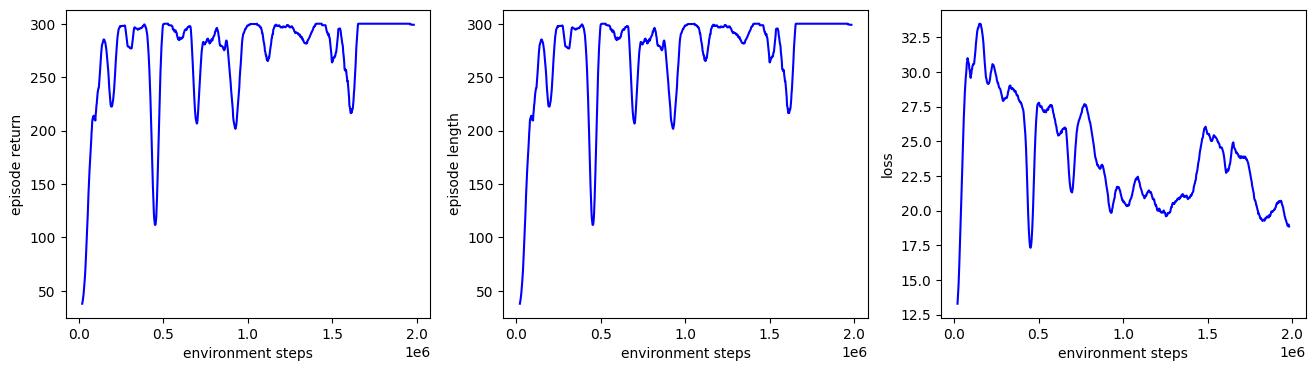

In [12]:
# A3.1a) Run the given REINFORCE algorithm

# Executing this code-block defines a new experiment
params = default_params()
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=ReinforceLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A3.1b) Add a value bias to REINFORCE <a id=q2></a>
Extend the `ReinforceLearner` class in the given Jupyter Notebook with a value function as bias (see slide 6 of Lecture 6). Implement two target-definitions for the value function, selected by the `'value_targets'` parameter: `'returns'` uses the returns `R_t` that are stored in the mini-batch, whereas `'td'` uses the TD-error. Make sure that the bias is ignored when the given parameter `'advantage_bias'` is `False`. Test your implementation as above on the evironment `Cartpole-v1` for 2M steps with the default parameters (using `’returns’` value targets).

*Hint:* The first heads of the model are interpreted as logits of a softmax policy, and the last head of
the model is interpreted as the value function.

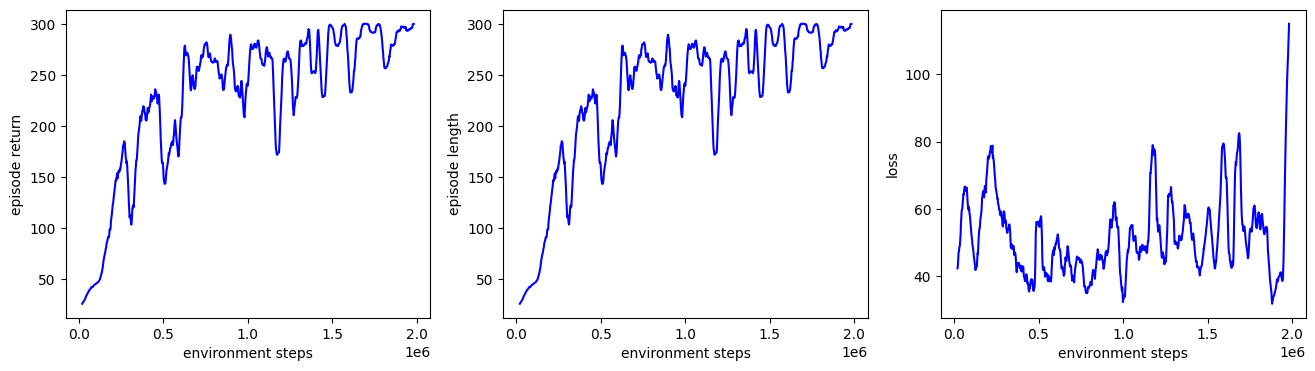

In [17]:
class BiasedReinforceLearner (ReinforceLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.advantage_bias = params.get('advantage_bias', True)
        self.value_targets = params.get('value_targets', 'returns')
        self.gamma = params.get('gamma')
        self.compute_next_val = (self.value_targets == 'td')
    
    # YOUR CODE HERE!!!
    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        if self.advantage_bias: return batch['returns'] - values
        return batch['returns']
    
    def _value_loss(self, batch, values=None, next_values=None):
        """ Computes the value loss (if there is one). """
        if self.advantatge_bias:
            value_targets = batch['returns']
            if self.value_targets == 'td':
                value_targets = batch['rewards'] + self.gamma * next_values.detach()
            return th.nn.functional.mse_loss(value_targets, values)
        return 0
    
# Executing this code-block defines a new experiment
params = default_params()
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=BiasedReinforceLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A3.1c) Add an advantage to REINFORCE <a id=q3></a>
Extend the `BiasedReinforceLearner` class in your implementation with an advantage function that uses bootstrapping (replaces `R_t` with `r_t + γV(s_{t+1})`, see slide 6 of Lecture 6). Make sure the original behavior is maintained when the parameter `advantage_bootstrap` is `False`. Test your implementation as above on the evironment `Cartpole-v1` for 2M steps with the default parameters.

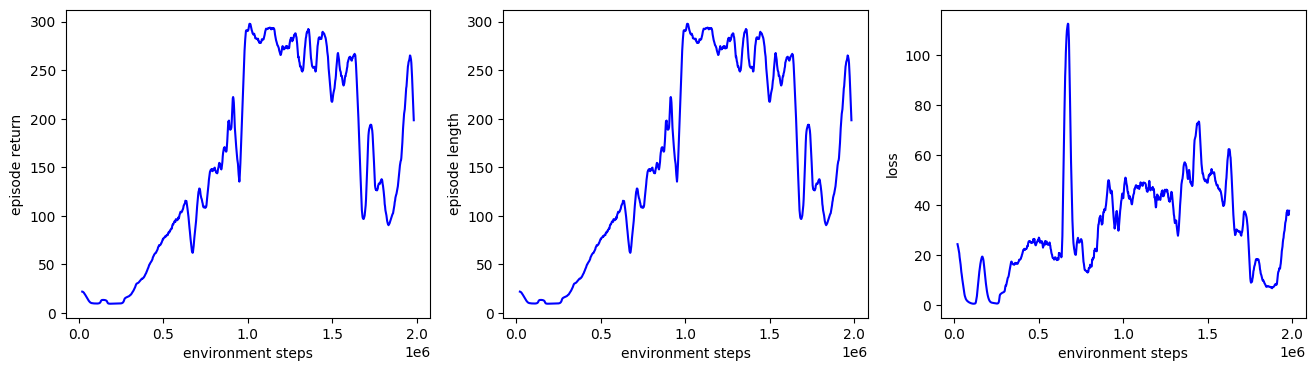

In [18]:
class ActorCriticLearner (BiasedReinforceLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.advantage_bootstrap = params.get('advantage_bootstrap', True)
        self.compute_next_val = self.compute_next_val or self.advantage_bootstrap
    
    # YOUR CODE HERE!!!
    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        if self.advantage_bootstrap: 
            return (batch['rewards'] + self.gamma*next_values) - values
        super()._advantages(batch, values, next_values)
        
# Executing this code-block defines a new experiment
params = default_params()
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=ActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A3.1d) Extend the actor-critic algorithm with off-policy updates <a id=q3></a>
Run your `ActorCriticLearner` with 80 off-policy iterations (by setting the parameter `params['offpolicy_iterations'] = 80`). Extend your implementation to the class `OffpolicyActorCriticLearner`, that uses on-policy gradients in the first and off-policy gradients in all following iterations (`L_µ` on slide 15 of Lecture 6). Test your implementation as above on the evironment `Cartpole-v1` with the default parameters, but only for 500*k* steps. 

*Hint:* `ReinforceLearner` has an attribute `old_pi` which is set to `None` at the beginning of `train()`. You can save the on-policy probabilities of the initial policy here to use them in the ratios of the off-policy loss.

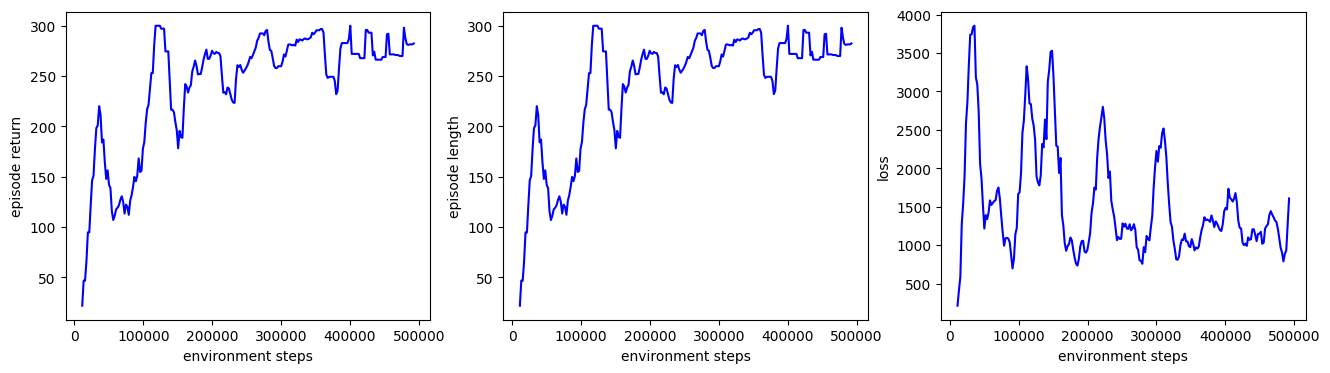

In [19]:
# Executing this code-block defines a new experiment
params = default_params()
params['offpolicy_iterations'] = 80
params['max_steps'] = int(5E5)
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]

# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=ActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

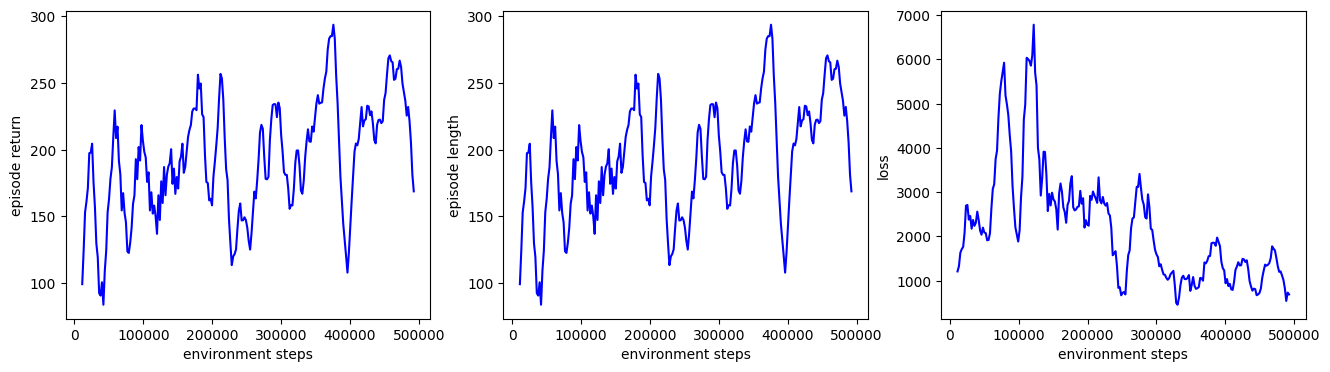

In [22]:
class OffpolicyActorCriticLearner (ActorCriticLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
    
    # YOUR CODE HERE!!!
    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        ratio = pi / self.old_pi
        return -(advantages.detach() * ratio).mean()
    
    def train(self, batch):
        assert self.controller is not None, "Before train() is called, a controller must be specified. "
        self.model.train(True)
        self.old_pi, loss_sum = None, 0.0
        for iteration in range(1 + self.offpolicy_iterations):
            # Compute the model-output for given batch
            out = self.model(batch['states'])   # compute both policy and values
            val = out[:, -1].unsqueeze(dim=-1)  # last entry are the values
            next_val = self.model(batch['next_states'])[:, -1].unsqueeze(dim=-1) if self.compute_next_val else None
            pi = self.controller.probabilities(out[:, :-1], precomputed=True).gather(dim=-1, index=batch['actions'])
            
            # Combine policy and value loss
            if iteration == 0: self.old_pi = pi.detach()
            loss = self._policy_loss(pi, self._advantages(batch, val, next_val)) \
                    + self.value_loss_param * self._value_loss(batch, val, next_val)
            
            # Backpropagate loss
            self.optimizer.zero_grad()
            loss.backward()
            grad_norm = th.nn.utils.clip_grad_norm_(self.all_parameters, self.grad_norm_clip)
            self.optimizer.step()
            loss_sum += loss.item()
        return loss_sum
                 
                
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A3.1e) Add PPO clipping to the off-policy actor critic  <a id=q5></a>
Now extend `OffpolicyActorCriticLearner` by adding PPO clipping to the off-policy loss (`L_µ^{clip}` on slide 18 of Lecture 6). Test your implementation as above on the evironment `Cartpole-v1` with the default parameters, but only for 500*k* steps.

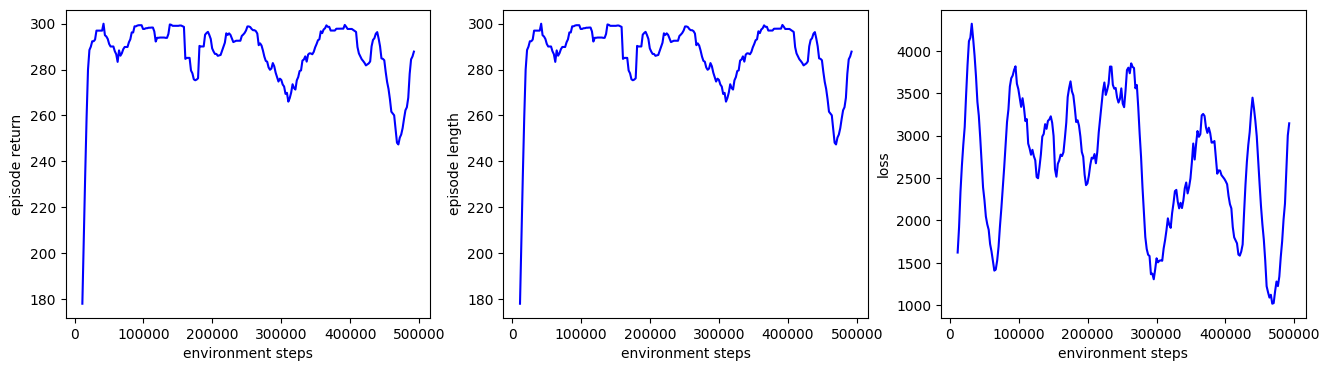

In [23]:
class PPOLearner (OffpolicyActorCriticLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.ppo_clipping = params.get('ppo_clipping', False)
        self.ppo_clip_eps = params.get('ppo_clip_eps', 0.2)
    
    # YOUR CODE HERE!!!
    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        if self.ppo_clipping:
            ratio = pi / self.old_pi
            clipped_ratio = th.clamp(ratio, 1 - self.ppo_clip_eps, 1 + self.ppo_clip_eps)
            return -(th.min(advantages.detach() * ratio, advantages.detach() * clipped_ratio)).mean()
        super()._policy_loss(pi, advantatges)
    
params = default_params()
params['offpolicy_iterations'] = 80
params['max_steps'] = int(5E5)
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]

# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=PPOLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A3.2: Policy optimization under constraints  <a id=q5></a>

Given $max_\pi \mathbb{E}[r | r \sim p(.|a), a \sim \pi(a)]$ we can apply the lagrange multiplier in order to solve the constrained problem. This leads us to have: <br><br>

- $L(\pi(a), \lambda) = \mathbb{E}[r | r \sim p(.|a), a \sim \pi(a)] + \lambda(- \sum_{a'} \pi(a')\ln{\pi(a')} - \epsilon)$
<br><br>

In order to find the extreme point, we have to equal to 0 the partial derivatives, which is equivalent to: <br><br>

- $\nabla_{\pi(a)} \mathbb{E}[r | r \sim p(.|a), a \sim \pi(a)] - \lambda (\nabla_{\pi(a)} \sum_{a'} \pi(a')\ln{\pi(a')} - \epsilon)$ <br><br>

The derivation of the first term is quite easy since equals to $Q(a)$ and teh derivation of the second term is:
<br><br>

- $\nabla_{\pi(a)} \sum_{a'} \pi(a')\ln{\pi(a')} - \epsilon = \nabla_{\pi(a)} \sum_{a'} \pi(a')\ln{\pi(a')}$ <br>
Given that only when $a = a'$ the gradient is not 0 this terms resumes into:
- $\nabla_{\pi(a)} \pi(a)\ln{\pi(a)}$
- $\nabla_{\pi(a)} \pi(a)\ln{\pi(a)} = \ln{\pi(a)}\nabla_{\pi(a)} \pi(a) + \pi(a) \nabla_{\pi(a)}\ln{\pi(a)}$
- $\nabla_{\pi(a)} \pi(a)\ln{\pi(a)} = \ln{\pi(a)} + 1$ <br><br>

This means the full derivation is: <br><br>

- $\nabla_{\pi(a)} \mathbb{E}[r | r \sim p(.|a), a \sim \pi(a)] - \lambda (\nabla_{\pi(a)} \sum_{a'} \pi(a')\ln{\pi(a')} - \epsilon) = Q(a) -\lambda(\ln{\pi(a)} + 1)$ <br><br>

That if we rearrenge the terms we get that: <br><br>

- $\pi(a) = \exp(\frac{Q(a) - \lambda}{\lambda})$ <br><br>

Given that $\sum_{a} Q(a) = 1$ we can add the term into the expression without changing the result, so if we change $\lambda$ by a term $\beta$ which we don't know to make it equivalent, with some more rearrangins we get the desires expression: <br><br>

- $\pi(a) = \frac{\exp(\beta Q(a))}{\sum_{a'} \exp(\beta Q(a'))}$

## A3.3: TD(1) is Monte-Carlo sampling  <a id=q5></a>

Let's prove analytically that in the limit $ \lambda \to 1$, the TD$\lambda$ targets $ V^{\pi}_{\lambda}(s) $ are identical to the Monte-Carlo targets $ V^{\pi}_{MC}(s) $.

Starting with the TD$\lambda$ target formula:
$V^{\pi}_{\lambda}(s_0) = (1-\lambda)\sum_{n=0}^{\infty} \lambda^n V^{\pi}_{n+1}(s_0)$

Now, let's express $ V^{\pi}_{n}(s_0) $ in terms of $ V^{\pi}_{MC}(s_0) $ using the provided hint:
$V^{\pi}_{n}(s_0) = \left(\sum_{t=0}^{n-1} \gamma^t r_t\right) + \gamma^n V^{\pi}_{MC}(s_n)$

Substituting this into the TD$\lambda$ target formula:
$V^{\pi}_{\lambda}(s_0) = (1-\lambda)\sum_{n=0}^{\infty} \lambda^n \left(\sum_{t=0}^{n-1} \gamma^t r_t + \gamma^n V^{\pi}_{MC}(s_n)\right)$

Now, let's rearrange the terms to separate the $ \gamma^n V^{\pi}_{MC}(s_n) $ term:
$V^{\pi}_{\lambda}(s_0) = (1-\lambda)\sum_{n=0}^{\infty} \lambda^n \sum_{t=0}^{n-1} \gamma^t r_t + (1-\lambda)\sum_{n=0}^{\infty} (\lambda\gamma)^n V^{\pi}_{MC}(s_n)$

Combine the two summations:
$V^{\pi}_{\lambda}(s_0) = (1-\lambda)\sum_{n=0}^{\infty} \lambda^n \sum_{t=0}^{n-1} \gamma^t r_t + (1-\lambda)\sum_{n=0}^{\infty} (\lambda\gamma)^n V^{\pi}_{MC}(s_n)$

Now, let's simplify the first term using the geometric series formula:
$V^{\pi}_{\lambda}(s_0) = (1-\lambda)\sum_{n=0}^{\infty} \lambda^n \frac{1-\gamma^n}{1-\gamma} \sum_{t=0}^{n-1} \gamma^t r_t + (1-\lambda)\sum_{n=0}^{\infty} (\lambda\gamma)^n V^{\pi}_{MC}(s_n)$

Distribute the $ \frac{1-\gamma^n}{1-\gamma} $ term:
$V^{\pi}_{\lambda}(s_0) = (1-\lambda)\sum_{n=0}^{\infty} \lambda^n \sum_{t=0}^{n-1} (1 + \gamma + \gamma^2 + \ldots + \gamma^{n-t-1}) r_t + (1-\lambda)\sum_{n=0}^{\infty} (\lambda\gamma)^n V^{\pi}_{MC}(s_n)$

Now, we can rearrange the terms:
$V^{\pi}_{\lambda}(s_0) = \sum_{t=0}^{\infty} \left(\sum_{n=t}^{\infty} (1-\lambda)\lambda^n(1 + \gamma + \gamma^2 + \ldots + \gamma^{n-t-1})\right) r_t + \sum_{n=0}^{\infty} (1-\lambda)(\lambda\gamma)^n V^{\pi}_{MC}(s_n)$

Now, let's analyze the term inside the parentheses:
$\sum_{n=t}^{\infty} (1-\lambda)\lambda^n(1 + \gamma + \gamma^2 + \ldots + \gamma^{n-t-1})$

Using the provided hint that $\lim_{\lambda\to 1} \lim_{m\to\infty} \lambda^m x_m = 0 $, we can consider $ (1-\lambda)\lambda^n $ as $ \lambda^n $ since $ \lambda \to 1 $. Now, the term becomes:
$\sum_{n=t}^{\infty} \lambda^n(1 + \gamma + \gamma^2 + \ldots + \gamma^{n-t-1})$

This is a geometric series, and we can express it as:
$\sum_{n=t}^{\infty} \lambda^n \frac{1-\gamma^{n-t}}{1-\gamma}$

Using the geometric series formula, this becomes:
$\frac{\lambda^t}{1-\lambda}$

Substituting this back into the main expression:
$V^{\pi}_{\lambda}(s_0) = \sum_{t=0}^{\infty} \frac{\lambda^t}{1-\lambda} r_t + \sum_{n=0}^{\infty} (1-\lambda)(\lambda\gamma)^n V^{\pi}_{MC}(s_n)$

Now, as $ \lambda \to 1 $, the first term $ \sum_{t=0}^{\infty} \frac{\lambda^t}{1-\lambda} r_t $ approaches 0 according to the provided hint. Therefore, we are left with:
$V^{\pi}_{\lambda}(s_0) = \lim_{\lambda\to 1} \sum_{n=0}^{\infty} (1-\lambda)(\lambda\gamma)^n V^{\pi}_{MC}(s_n)$

Now, let's simplify this expression:
$V^{\pi}_{\lambda}(s_0) = \lim_{\lambda\to 1} \frac{1-\lambda}{1-\lambda\gamma} \sum_{n=0}^{\infty} (\lambda\gamma)^n V^{\pi}_{MC}(s_n)$

Using the geometric series formula again, the term inside the sum becomes:
$\frac{1}{1-\lambda\gamma}$

Therefore:
$V^{\pi}_{\lambda}(s_0) = \lim_{\lambda\to 1} \frac{1-\lambda}{1-\lambda\gamma} \cdot \frac{1}{1-(\lambda\gamma)} V^{\pi}_{MC}(s_0)$

Simplify further:
$V^{\pi}_{\lambda}(s_0) = \lim_{\lambda\to 1} V^{\pi}_{MC}(s_0)$

As $\lambda \to 1$, the TD$\lambda$ target $V^{\pi}_{\lambda}(s_0)$ converges to


## A3.4: Random exploration decays exponentially   <a id=q5></a>

### a)

We know that $\mathcal{E}_t^{\pi}(s) = P(s | s', a)\pi(a|s')\mathcal{E}_{t-1}^{\pi}(s')$ <br><br>

Given the policy is random this is equivalent to: <br><br>

- $\mathcal{E}_t^{\pi}(s) = \frac{1}{4}P(s | s', a)\mathcal{E}_{t-1}^{\pi}(s')$ <br><br>

Given all the transitions in the transition model are deterministic and we know their output we can simplify this in terms of the distriutions of the previous state in the previus timestamp: <br><br>

- $\mathcal{E}_t^{\pi}(s) = \frac{1}{4}[\mathcal{E}_{t-1}^{\pi}(s+1) + 2\mathcal{E}_{t-1}^{\pi}(s) + \mathcal{E}_{t-1}^{\pi}(s-1)]$

### b)

First of all given the restrictions, we know that $\mathcal{E}_0^{\pi}(0) = 1$.<br>
Given this statement, we can prove $\mathcal{E}_t^{\pi}(s) = \frac{1}{4^t}\binom{2t}{t+s}$ by induction.<br><br>

- Base case t = 0:

$\mathcal{E}_0^{\pi}(0) = \frac{1}{4^0}\binom{0}{0} = 1$

- Recursive case with induction hypothesis = $\mathcal{E}_{t-1}^{\pi}(s) = \frac{1}{4^{t-1}}\binom{2(t-1)}{t-1+s}$
<br><br>

By the definition in the previous exercise we have:

$\mathcal{E}_t^{\pi}(s) = \frac{1}{4}[\mathcal{E}_{t-1}^{\pi}(s+1) + 2\mathcal{E}_{t-1}^{\pi}(s) + \mathcal{E}_{t-1}^{\pi}(s-1)]$ <br><br>

That by subtitution with the hypothesis we get:

$\mathcal{E}_t^{\pi}(s) = \frac{1}{4}[\frac{1}{4^{t-1}} [\binom{2(t-1)}{t-1+s+1} + 2\binom{2(t-1)}{t-1+s}] + \binom{2(t-1)}{t-1+s-1}]$<br>

$\mathcal{E}_t^{\pi}(s) = \frac{1}{4^t} [\binom{2(t-1)}{t-1+s+1} + 2\binom{2(t-1)}{t-1+s} + \binom{2(t-1)}{t-1+s-1}]$<br>

$\mathcal{E}_t^{\pi}(s) = \frac{1}{4^t} [\binom{2(t-1)}{t-1+s+1} + \binom{2(t-1)}{t-1+s} + \binom{2(t-1)}{t-1+s} + \binom{2(t-1)}{t-1+s-1}]$ <br>

$\mathcal{E}_t^{\pi}(s) = \frac{1}{4^t} [\binom{2t-2)}{t + s} + \binom{2t-2}{t-1+s} + \binom{2t-2}{t-1+s} + \binom{2t-2)}{t-1+s-1}]$ <br><br> 

Applying the hint propotionated in the exercise 2 times recursively we get the analytical prove by induction:

$\mathcal{E}_t^{\pi}(s) = \frac{1}{4^t} [\binom{2t-1}{t+s} + \binom{2t-1}{t+s-1}]$ <br>
$\mathcal{E}_t^{\pi}(s) = \frac{1}{4^t} \binom{2t}{t+s}$

### c)

## A3.5: Epistemic uncertainty   <a id=q5></a>

### a) 

We have: <br><br>

- $E_Z[(g(z) - \alpha)^2] = V_Z[g(z)] + (E_Z[g(z)] - \alpha)^2$

If we develop the left side we get:

- $E_Z[(g(z) - \alpha)^2] = E_Z[g(z)^2 - 2\alpha g(z)+ \alpha^2]$
- $E_Z[(g(z) - \alpha)^2] = E_Z[g(z)^2] - 2\alpha E_Z[g(z)]+ \alpha^2$

If we develop th eright side we get: 

- $V_Z[g(z)] + (E_Z[g(z)] - \alpha)^2 = E_Z[g(z)^2] - E_Z[g(z)]^2 +(E_Z[g(z)] - \alpha)^2$
- $V_Z[g(z)] + (E_Z[g(z)] - \alpha)^2 = E_Z[g(z)^2] - E_Z[g(z)]^2 + E_Z[g(z)]^2 - 2\alpha E_Z[g(z)] +\alpha^2$
- $V_Z[g(z)] + (E_Z[g(z)] - \alpha)^2 = E_Z[g(z)^2] - 2\alpha E_Z[g(z)] +\alpha^2$

That is the same expression that we got on the right side thus the equality holds.

### b) 

$E_D[E_x[E_y[(y - f_D(x))^2 | x]]] = E_x[\sigma^2(x)] + E_x[V_D[f_D(x) | x]]$

Firstly, expand the expression:


$E_D[E_x[E_y[(y - f_D(x))^2 | x]]] = E_D[E_x[E_y[y^2 - 2yf_D(x) + (f_D(x))^2 | x]]]$

Now, apply the linearity of expectations:


$ = E_D[E_x[E_y[y^2 | x] - 2E_y[y | x]f_D(x) + (E_y[(f_D(x))^2 | x])]] $

Since \(y\) follows a normal distribution \(N(\mu(x), \sigma^2(x))\), we can write:

$ = E_D[E_x[\left(\mu(x)^2 + \sigma^2(x)\right) - 2\mu(x)f_D(x) + (V_y[f_D(x) | x] + (E_y[f_D(x) | x])^2)\]] $

Now, simplify further by rearranging terms:

$ = E_D[E_x[\sigma^2(x) + (E_y[f_D(x) | x] - \mu(x))^2 + V_y[f_D(x) | x] - E_y[(f_D(x))^2 | x]]] $

Now, focus on the inner expectation with respect to \(x\):

$ E_x[\sigma^2(x) + (E_y[f_D(x) | x] - \mu(x))^2 + V_y[f_D(x) | x] - E_y[(f_D(x))^2 | x]] $

Combine the terms to obtain:

$ = E_x[\sigma^2(x) + V_y[f_D(x) | x] + (E_y[f_D(x) | x] - \mu(x))^2 - E_y[(f_D(x))^2 | x]] $

Taking the outer expectation with respect to \(x\) gives the final expression:

$ E_D[E_x[\sigma^2(x) + V_y[f_D(x) | x] + (E_y[f_D(x) | x] - \mu(x))^2 - E_y[(f_D(x))^2 | x]]] $


$= E_x[\sigma^2(x)] + E_x[V_y[f_D(x) | x]] + E_x[(E_y[f_D(x) | x] - \mu(x))^2] - E_x[E_y[(f_D(x))^2 | x]] $

Now, notice that $(E_x[E_y[(f_D(x))^2 | x]] = E_x[V_D[f_D(x) | x]]$, where $V_D[f_D(x) | x]$ is the variance of $f_D(x)$ over different datasets $D$. Therefore, the expression becomes:

$ = E_x[\sigma^2(x)] + E_x[V_D[f_D(x) | x]] + E_x[(E_y[f_D(x) | x] - \mu(x))^2] - E_x[V_D[f_D(x) | x]] $

Finally, combining the variance terms gives:

$= E_x[\sigma^2(x)] + E_x[V_D[f_D(x) | x]]$

This completes the proof.


### c)

Prove that the epistemic uncertainty of the empirical mean $f_D = \frac{1}{n} \sum_{t=1}^{n} y_t$ for the labels of one constant input sample $x_t = x, \forall t$, is given by $V_D[f_D(x) | x] = \frac{\sigma^2(x)}{n}$.**

Starting with the definition of $f_D$:

$f_D = \frac{1}{n} \sum_{t=1}^{n} y_t$

Now, the epistemic uncertainty is the variance of this empirical mean $f_D$ over different datasets $D$. Let's calculate it:

$V_D[f_D(x) | x] = E_D\left[\left(f_D(x) - E_D[f_D(x) | x]\right)^2\right]$

Firstly, calculate the expectation $E_D[f_D(x) | x]$:

$E_D[f_D(x) | x] = E_D\left[\frac{1}{n} \sum_{t=1}^{n} y_t | x\right] = \frac{1}{n} \sum_{t=1}^{n} E_D[y_t | x] = \frac{1}{n} \sum_{t=1}^{n} \mu(x) = \mu(x)$

Now, substitute this into the expression for the variance:

$V_D[f_D(x) | x] = E_D\left[\left(\frac{1}{n} \sum_{t=1}^{n} y_t - \mu(x)\right)^2\right]$

Since the $y_t$ are drawn i.i.d. from $N(\mu(x), \sigma^2(x))$, each term in the sum is also i.i.d. Apply the variance formula for the sum of i.i.d. random variables:

$= \frac{1}{n^2} \sum_{t=1}^{n} V_D[y_t | x] = \frac{1}{n^2} \sum_{t=1}^{n} \sigma^2(x) = \frac{n \sigma^2(x)}{n^2} = \frac{\sigma^2(x)}{n}$

Therefore, we have shown that $V_D[f_D(x) | x] = \frac{\sigma^2(x)}{n}$, which completes the proof.
